In [1]:
random_state = 9999
image_output_params = {'width': 1080, 'height': 600, 'scale': 6}
render = 'svg' #or None to have interactive plots

# Machine-Learning
Set-up

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split # Random Split
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/clean_listing.csv', index_col=0)
# Split data and drop unnecessary data
Y = df['price']
X = df.drop(['price', 'latitude', 'longitude'], axis=1)
X = X.astype('float64')
X.head()
# Storage
result = {'Method':[], 'Train R2':[], 'Train RMSE':[], 'Test R2': [], 'Test RMSE': []}

In [4]:
f"The standard deviation of price of listing is ${df['price'].std():.2f}."

'The standard deviation of price of listing is $132.36.'

In [5]:
def update_frame(frame: dict, y_train, y_train_pred, y_true, y_pred, method_name):
    frame['Method'].append(method_name)
    frame['Train R2'].append(r2_score(y_train, y_train_pred))
    frame['Train RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    frame['Test R2'].append(r2_score(y_true, y_pred))
    frame['Test RMSE'].append(np.sqrt(mean_squared_error(y_true, y_pred)))

def calculate_score(y_true, y_pred):
    print(f"R2 Score {r2_score(y_true, y_pred)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}")

def plot(y_true, y_pred, title, band=True):
    # Plotly express plot
    h = pd.DataFrame(data={'Actual y':y_true, 'Predicted y': y_pred})
    RMSE = df['price'].std()

    fig = px.scatter(h, x='Actual y', y='Predicted y', title=title)
    fig.add_trace(go.Scatter(x=[0, 600],y=[0, 600],mode="lines",line=go.scatter.Line(color='gray'),showlegend=False)) #Diagonal Line
    if band:
        fig.add_traces([
            go.Scatter(x=[0, 600],y=[0+RMSE, 600+RMSE],mode='lines',line=go.scatter.Line(dash='dot'),showlegend=False),
            go.Scatter(x=[0, 600],y=[0-RMSE, 600-RMSE],mode='lines',line=go.scatter.Line(dash='dot'),showlegend=False)
            ])
    fig.show(render)
    return fig

def simulate(model, XXyy, name: str):
    # Model must be fitted and implement predict, score methods.
    # XXyy: X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = XXyy
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    update_frame(result, y_train, y_train_pred, y_test, y_pred, name)

    print(f"Train\n Score: {model.score(X_train, y_train)}")
    calculate_score(y_train, y_train_pred)

    print(f"Test\n Score: {model.score(X_test, y_test)}")
    calculate_score(y_test, y_pred)
    
    fig = plot(y_test, y_pred, name)
    fig.write_image(f'images/{name}.png', **image_output_params)

def feature_plot(feature_name, feature_score, name: str):
    feature_importance = pd.DataFrame({'Feature': feature_name, 'Score': feature_score})
    feature_importance.sort_values(by='Score', axis=0, inplace=True, ascending=False)

    fig = px.bar(feature_importance.head(20), x='Score', y='Feature', orientation='h')

    fig.update_layout(title={'text': f'{name} Most Relevant Feature'})
    fig.show(render)
    fig.write_image(f'images/{name} Most Relevant Feature.png', **image_output_params)

    fig = px.bar(feature_importance.tail(20), x='Score', y='Feature', orientation='h')
    fig.update_layout(title={'text': f'{name} Least Relevant Feature'})
    fig.show(render)
    fig.write_image(f'images/{name} Least Relevant Feature.png', **image_output_params)
        

# Part 1:
Finding a model that best predicts price. We will being trying :
- linear model: Linear Regression
- tree-based model: HistGradientBoostRegressor, XGBoost
- and to try something new: Neural Network.

We will be using $R^2$ score to compare the goodness of the model, and RMSE to find the accuracy of the prediction.

### Model 1: Linear Regression

We first use linear regression, a method taught for predicting numerical values.

In [6]:
XXyy = X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

Train
 Score: 0.5823262242502851
R2 Score 0.5823262242502851
RMSE : 86.11207306211794
Test
 Score: 0.5940275128205484
R2 Score 0.5940275128205484
RMSE : 81.75302133242347


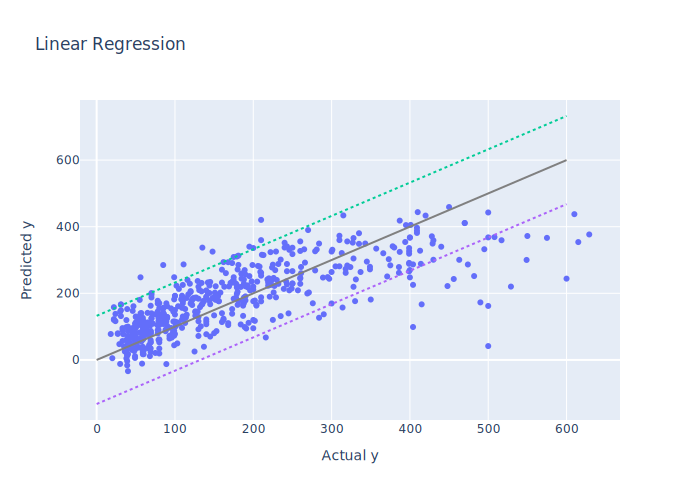

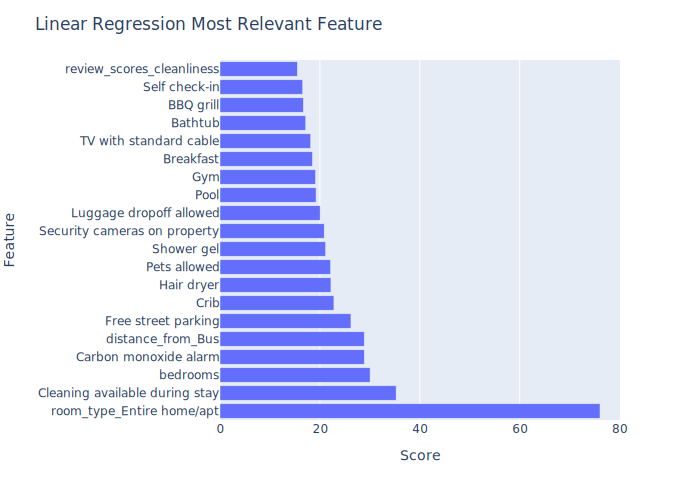

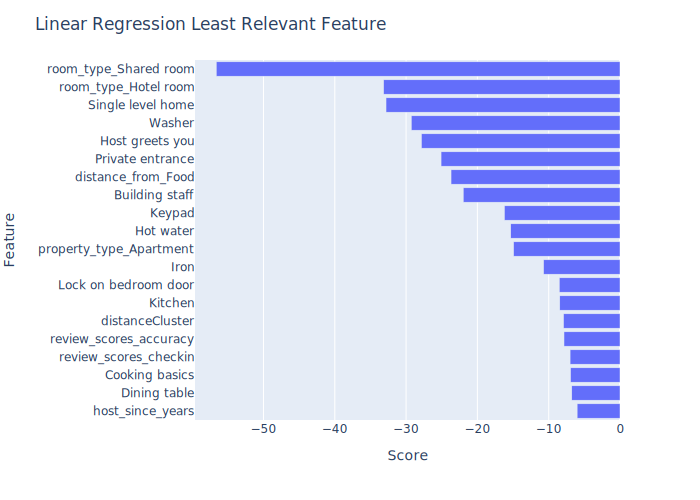

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

simulate(model, XXyy, 'Linear Regression')
feature_plot([col for col in X.columns], [model.coef_[i].round(5) for i in range(len(X.columns))], 'Linear Regression')

### Model 2: Gradient Boost Regressor

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will be using HistGradientBoostingRegressor from sklearn.

Train
 Score: 0.9999564626510026
R2 Score 0.9999564626510026
RMSE : 0.879177228628682
Test
 Score: 0.8670399426447051
R2 Score 0.8670399426447051
RMSE : 46.7860205759534


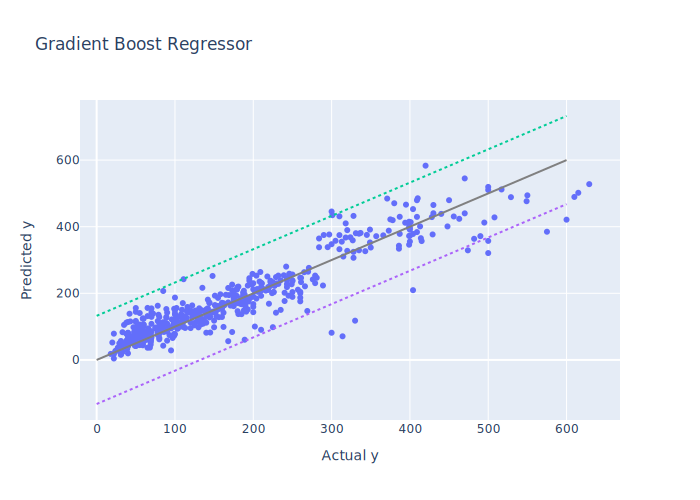

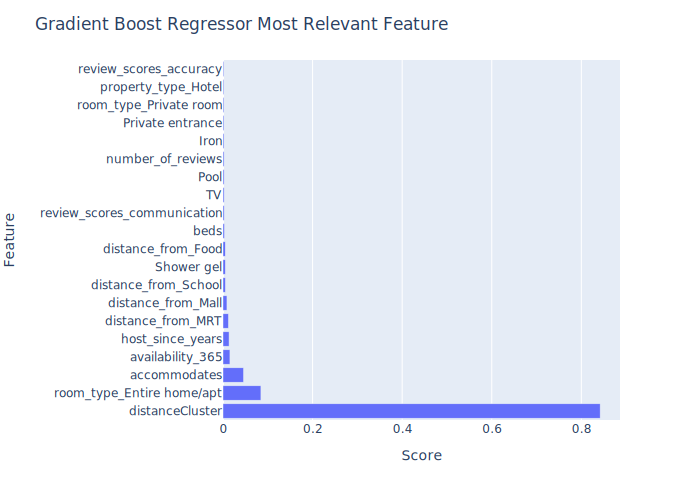

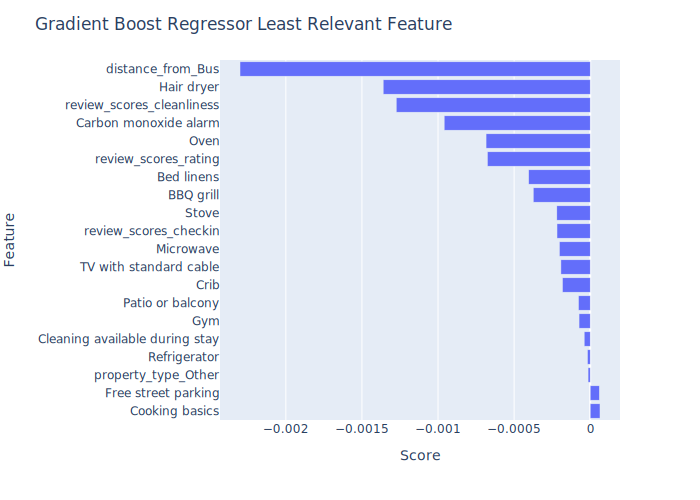

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=random_state, max_iter=1000)

model.fit(X_train, y_train)

simulate(model, XXyy, name='Gradient Boost Regressor')

feature_plot(model.feature_names_in_, 
             permutation_importance(model, X_test, y_test, random_state=random_state).importances_mean, 
             'Gradient Boost Regressor')

### Model 3: XGBoost Regression

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will use XGBoost API to do the model fitting.

Train
 Score: 0.9955051612926696
R2 Score 0.9955051612926696
RMSE : 8.93310618774021
Test
 Score: 0.8608741124146471
R2 Score 0.8608741124146471
RMSE : 47.858544293822604


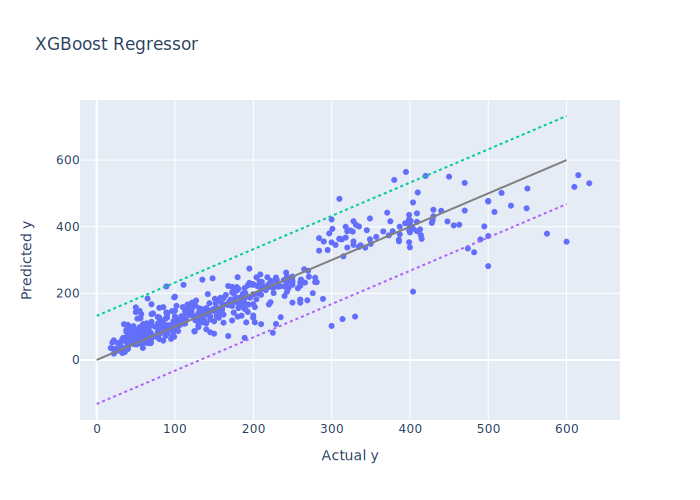

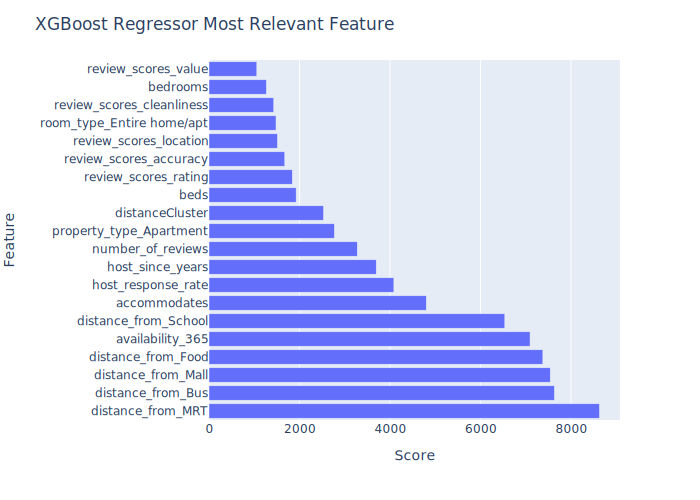

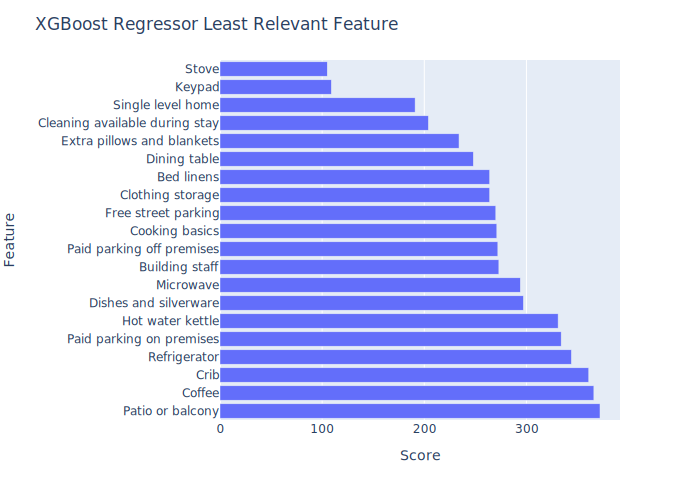

In [9]:
import xgboost as xgb

model = xgb.sklearn.XGBRegressor(tree_method='hist', objective='reg:squarederror', n_estimators = 2500,
                         learning_rate=0.01, random_state=random_state)

model.fit(X_train, y_train)

simulate(model, XXyy, 'XGBoost Regressor')

booster = model.get_booster()
feature_plot(booster.get_score().keys(), booster.get_score().values(), 'XGBoost Regressor')

### Model 4: Neural Networks

We will be using Sklearn MLPRegressor, short for Multi-layer Perception Regressor. Model optimizes for lowest squarer error by gradient descent.

Train
 Score: 0.7891249418804447
R2 Score 0.7891249418804447
RMSE : 61.18684330443584
Test
 Score: 0.6627136273339647
R2 Score 0.6627136273339647
RMSE : 74.51692206706014


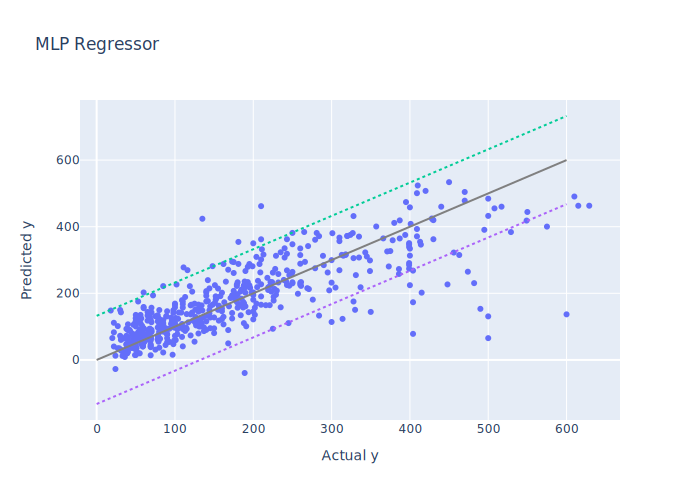

In [10]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=random_state, max_iter=1000).fit(X_train, y_train)

simulate(model, XXyy, 'MLP Regressor')

We can conclude that HistGradientBoostingRegressor and XGBoost Regressor achieve the best results, with the lowest RMSE (~46) and the higher R^2 score (~0.86). All other models achieve decent results, with RMSE around half of standard deviation, and R^2 > 0.5.

# Part 2: Optimising models

We will be using RandomizedSearchCV, GridSearchCV to find the optimal parameters.
- Benefit: Can finds optimal values between the 'grid' in a GridSearchCV, do not need prior experience & intuition.
- Downside: Takes significantly longer to find optimal values.

In [11]:
from scipy.stats import loguniform
# Code from scikit-learn-mooc
class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = HistGradientBoostingRegressor(random_state=random_state)

param_distributions = {
    'max_bins': loguniform_int(2, 255),
    'max_leaf_nodes': loguniform_int(2, 256),
    'min_samples_leaf': loguniform_int(1, 100),
    'learning_rate': loguniform(0.001, 10),
}

cv = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=350, cv=3, n_jobs=-1, scoring=['neg_mean_squared_error', 'r2'], refit='r2') .fit(X_train, y_train)

v = pd.DataFrame(cv.cv_results_)
v.sort_values(by='rank_test_r2', inplace=True)
display(v.head(10))

print(f"Best parameters: {cv.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_bins,param_max_leaf_nodes,param_min_samples_leaf,params,split0_test_neg_mean_squared_error,...,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
24,0.360697,0.023792,0.009875,0.002042,0.073989,7,73,17,"{'learning_rate': 0.07398948695048085, 'max_bi...",-2383.752025,...,-2419.494402,-2576.504278,247.749254,2,0.862413,0.848673,0.851451,0.854179,0.005931,1
40,0.242956,0.018818,0.005565,0.001393,0.137448,5,33,2,"{'learning_rate': 0.137448332201839, 'max_bins...",-2360.969743,...,-2497.583051,-2575.965476,214.815977,1,0.863728,0.851617,0.846656,0.854000,0.007170,2
81,0.763146,0.012133,0.014725,0.005978,0.179016,4,89,2,"{'learning_rate': 0.17901616844049245, 'max_bi...",-2393.209796,...,-2492.071881,-2589.012247,210.898390,3,0.861867,0.850975,0.846995,0.853279,0.006286,3
47,0.373727,0.025309,0.005732,0.000363,0.09415,109,35,10,"{'learning_rate': 0.09414953721534623, 'max_bi...",-2340.794932,...,-2480.148688,-2613.458479,292.649542,4,0.864892,0.843856,0.847727,0.852158,0.009142,4
289,0.300651,0.013534,0.007095,0.001692,0.092741,22,30,12,"{'learning_rate': 0.09274128848503392, 'max_bi...",-2387.648918,...,-2459.250116,-2617.289431,275.685110,5,0.862188,0.844603,0.849010,0.851934,0.007470,5
86,0.531701,0.017890,0.010518,0.008066,0.154527,29,40,5,"{'learning_rate': 0.1545271122101208, 'max_bin...",-2494.561687,...,-2404.629051,-2617.289683,239.980719,6,0.856017,0.847308,0.852363,0.851896,0.003571,6
255,0.295769,0.018310,0.009572,0.001819,0.067447,22,33,14,"{'learning_rate': 0.06744716964048772, 'max_bi...",-2331.286834,...,-2429.336119,-2625.806375,349.482142,8,0.865441,0.838821,0.850846,0.851703,0.010885,7
336,0.771524,0.012537,0.012678,0.003727,0.052448,4,123,2,"{'learning_rate': 0.05244767634061531, 'max_bi...",-2480.729761,...,-2509.223554,-2619.542760,176.546719,7,0.856815,0.851652,0.845942,0.851469,0.004441,8
248,0.654156,0.037000,0.008778,0.001409,0.035193,121,177,15,"{'learning_rate': 0.03519324145202685, 'max_bi...",-2353.979740,...,-2458.982811,-2633.298272,323.619387,9,0.864131,0.840365,0.849026,0.851174,0.009821,9
76,0.700533,0.055128,0.011615,0.005411,0.188878,20,50,6,"{'learning_rate': 0.18887799687588078, 'max_bi...",-2435.441249,...,-2385.203637,-2650.738551,340.617742,11,0.859429,0.838057,0.853556,0.850347,0.009016,10


Best parameters: {'learning_rate': 0.07398948695048085, 'max_bins': 7, 'max_leaf_nodes': 73, 'min_samples_leaf': 17}


We can see that parameters with rank 1 has higher R^2 score. 

Train
 Score: 0.9802633392309591
R2 Score 0.9802633392309591
RMSE : 18.718984242227716
Test
 Score: 0.8825962410607566
R2 Score 0.8825962410607566
RMSE : 43.96393039472644


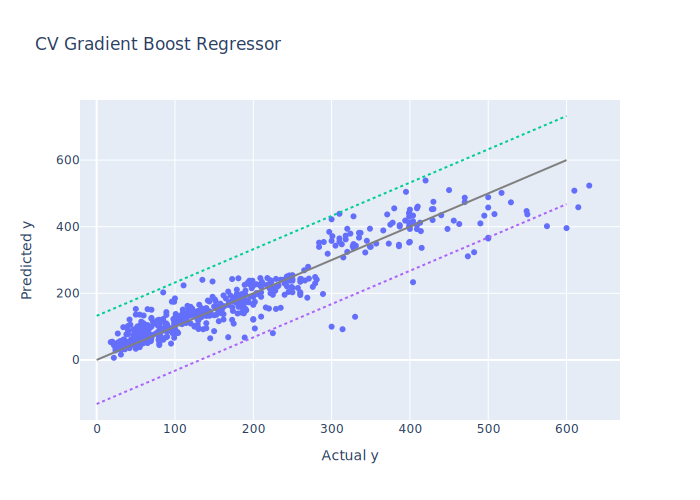

In [13]:
model = HistGradientBoostingRegressor(**cv.best_params_, random_state=random_state).fit(X_train, y_train)
simulate(model, XXyy, 'CV Gradient Boost Regressor')

### Tuning XGBoost Regressor

Parameters to tune:
- n estimators & learning_rate: Takes longer to achieve same error reduction, however smaller steps taken means we can find the optimal minimum
- max_leaves (default 0): By restricting max leaves, we can reduce overfitting.
- colsample_bytree (default 1): Fraction of columns to be randomly sampled, might reduce overfitting.
- subsample (default 1): Fraction of observations to sample for each tree, lower values reduce overfitting.

In [14]:
model = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', seed=random_state)

params_grid = {
    'n_estimators': [1000, 1500],
    'learning_rate': [0.03, 0.05],
    'max_leaves': [0, 20, 40, 60, 80],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'subsample': [0.6, 0.8, 1],
}

cv = GridSearchCV(estimator=model, param_grid=params_grid, cv=3, n_jobs=-1, scoring=['neg_mean_squared_error', 'r2'], refit='r2').fit(X_train, y_train)

v = pd.DataFrame(cv.cv_results_)
v.sort_values(by='rank_test_r2', inplace=True)
display(v.head(10))

print(f"Best parameters: {cv.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_leaves,param_n_estimators,param_subsample,params,...,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
88,2.830587,0.024460,0.031152,0.003864,0.6,0.03,80,1500,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2297.868879,-2464.282240,219.874247,2,0.866092,0.856498,0.858918,0.860502,0.004074,1
64,2.737261,0.038529,0.040129,0.011058,0.6,0.03,0,1500,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2297.868879,-2464.282240,219.874247,2,0.866092,0.856498,0.858918,0.860502,0.004074,1
85,1.842851,0.009947,0.019751,0.001046,0.6,0.03,80,1000,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2296.423409,-2464.505251,220.285796,4,0.866012,0.856460,0.859007,0.860493,0.004039,3
61,1.842453,0.040160,0.017211,0.002338,0.6,0.03,0,1000,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2296.423409,-2464.505251,220.285796,4,0.866012,0.856460,0.859007,0.860493,0.004039,3
82,2.810578,0.073919,0.026985,0.001425,0.6,0.03,60,1500,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2324.674019,-2464.239887,202.031189,1,0.866201,0.857792,0.857272,0.860422,0.004092,5
79,1.821847,0.035961,0.019390,0.001309,0.6,0.03,60,1000,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2322.779940,-2464.673204,202.279221,6,0.866063,0.857751,0.857389,0.860401,0.004007,6
73,1.755185,0.021500,0.033678,0.000214,0.6,0.03,40,1000,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2325.216159,-2478.692135,205.061489,8,0.864803,0.856831,0.857239,0.859624,0.003666,7
76,2.667321,0.065299,0.037594,0.004943,0.6,0.03,40,1500,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2334.001679,-2480.841267,200.086862,9,0.864662,0.857078,0.856700,0.859480,0.003667,8
80,1.734880,0.034987,0.022632,0.003654,0.6,0.03,60,1000,1,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2369.587151,-2478.004789,140.804983,7,0.862192,0.861571,0.854515,0.859426,0.003482,9
86,1.759869,0.077423,0.023635,0.002532,0.6,0.03,80,1000,1,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-2393.123964,-2481.498472,148.713618,10,0.863760,0.860842,0.853070,0.859224,0.004512,10


Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_leaves': 0, 'n_estimators': 1500, 'subsample': 0.8}


Train
 Score: 0.9995620707899414
R2 Score 0.9995620707899414
RMSE : 2.788350711515214
Test
 Score: 0.8717384211367947
R2 Score 0.8717384211367947
RMSE : 45.95193473668479


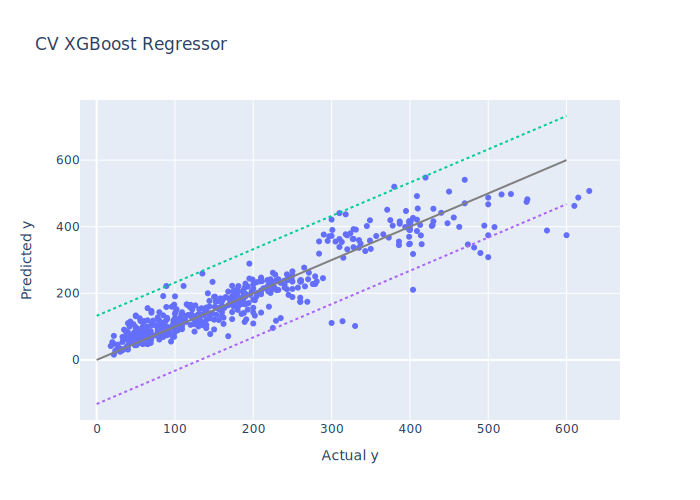

In [15]:
model = xgb.XGBRegressor(**cv.best_params_,).fit(X_train, y_train)
simulate(model, XXyy, 'CV XGBoost Regressor')

For XGBoost Regression, with parameters tuned, it is the best model, with R^2 score of 0.88 and RMSE score of 43.

Using Hyperopt-Sklearn, which is a wrapper of Hyperopt, a library for Distributed Asynchronous Hyper-parameter Optimization.

100%|██████████| 20/20 [00:00<00:00,  1.10trial/s, best loss: 0.170521002095396]
Train
 Score: 0.9178291420135207
R2 Score 0.9178291420135207
RMSE : 38.19480976014854
Test
 Score: 0.8435831933395767
R2 Score 0.8435831933395767
RMSE : 50.74546286863594


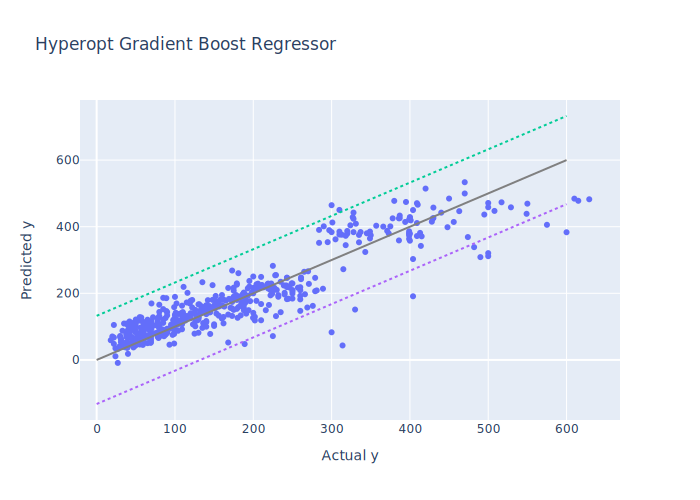

In [16]:
from hpsklearn import HyperoptEstimator, hist_gradient_boosting_regressor, xgboost_regression
from hyperopt import tpe

model = HyperoptEstimator(
    regressor=hist_gradient_boosting_regressor('HGBR'),
    preprocessing=[],
    algo=tpe.suggest,
    max_evals=20,
    n_jobs=-1,
    seed=random_state)
model.fit(X_train, y_train)

simulate(model, XXyy, 'Hyperopt Gradient Boost Regressor')

100%|██████████| 10/10 [00:01<00:00,  1.10s/trial, best loss: 0.15339382573226468]
Train
 Score: 0.9591944440393267
R2 Score 0.9591944440393267
RMSE : 26.91566349771768
Test
 Score: 0.8679487008537653
R2 Score 0.8679487008537653
RMSE : 46.625859397538036


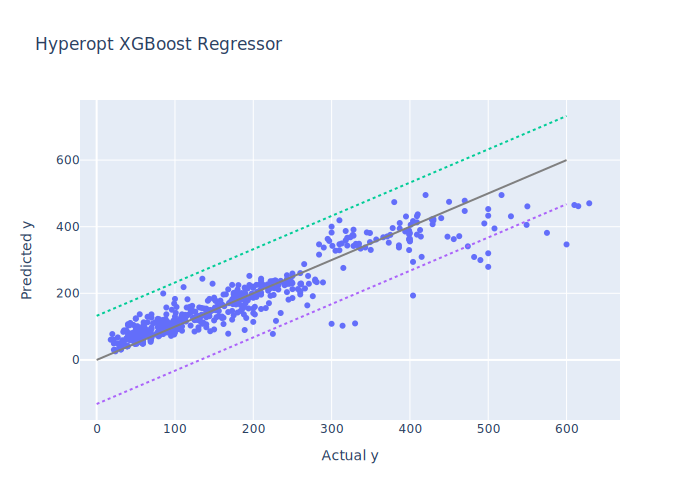

In [17]:
model = HyperoptEstimator(
    regressor=xgboost_regression('XGBR'),
    preprocessing=[],
    algo=tpe.suggest,
    max_evals=10,
    n_jobs=-1,
    seed=random_state)
model.fit(X_train, y_train)

simulate(model, XXyy, 'Hyperopt XGBoost Regressor')

From the optimization results above, we can see that achieving ~45 RMSE, ~0.87 $R^2$ is the best result we can get.

From the plots and the RMSE, $R^2$ values, we can see that the prediction runs well when $0 \leq price \leq 300$ and as price prediction is less accurate when $300 < price$. One reason for higher prices listing to be inaccurate would be that any speciality of the house, like renovation, is only observable through listing picture and cannot be analyzed numerically or categorically. Further improvements can be made if we attempt to anaylze listing description using sentiment analysis etc.

In [18]:
# Save for analysis
pd.DataFrame(result).to_csv('data/model_results.csv')

In [19]:
observartion = pd.read_csv('data/model_results.csv', index_col=0)
obs_RMSE = observartion.sort_values(by='Test RMSE', ascending=False)
obs_R2 = observartion.sort_values(by='Test R2')

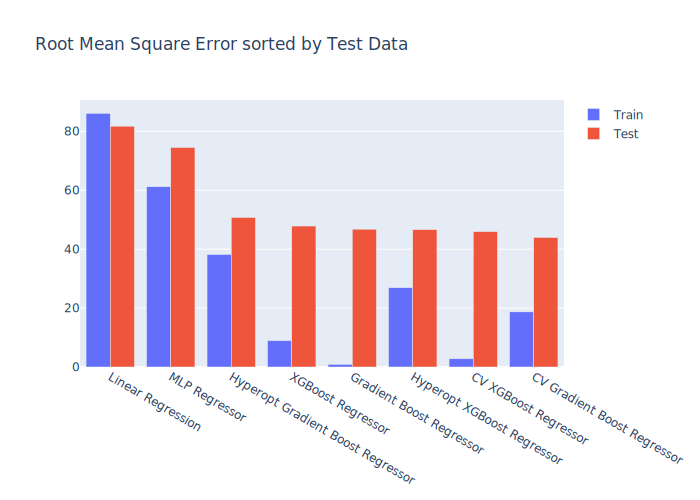

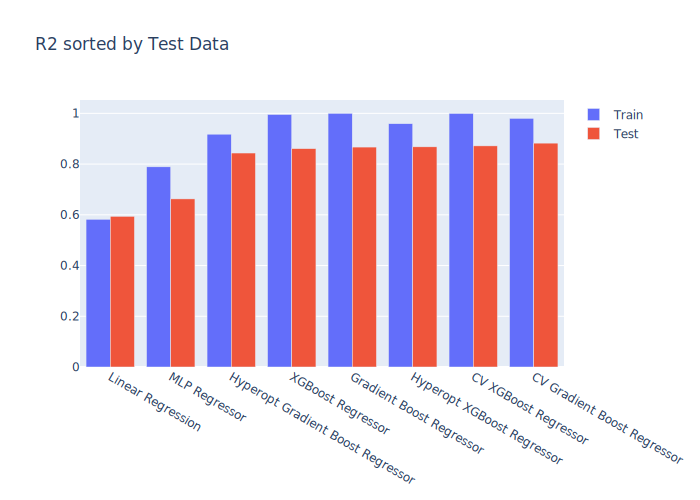

In [20]:
fig = go.Figure(data=[
        go.Bar(name='Train', x=obs_RMSE['Method'], y=obs_RMSE['Train RMSE']),
        go.Bar(name='Test', x=obs_RMSE['Method'], y=obs_RMSE['Test RMSE'])
    ], layout={'title': 'Root Mean Square Error sorted by Test Data'})
fig.show(render)
fig.write_image('images/RMSE Analysis.png', **image_output_params)

fig = go.Figure(data=[
        go.Bar(name='Train', x=obs_R2['Method'], y=obs_R2['Train R2']),
        go.Bar(name='Test', x=obs_R2['Method'], y=obs_R2['Test R2'])
    ], layout={'title': 'R2 sorted by Test Data'})
fig.show(render)
fig.write_image('images/R2 Analysis.png', **image_output_params)